<a href="https://colab.research.google.com/github/JoaoV2405/IC-Visao-Computacional/blob/main/modelos/Modelo_PointNet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==2.1.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install openmesh
import openmesh
from torch_geometric.io import read_ply
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints

# !pip install open3d
!pip install numpy
import numpy as np
import torch
import pandas as pd
import os
from torch_geometric.data import Data, Dataset


2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 48.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openmesh: filename=openmesh-1.2.1-cp310-cp310-linux_x86_64.whl size=855151 sha256=b1459f68419588c9bb564da49ff75d9f1ef06c98c228287ad62c288aea46e478
  Stored in directory: /root/.cache/pip/wheels/05/52/ac/4cf307e2dac381ab093a0390901305aee1110ca733ebf55d55
Successfully built openmesh


In [ ]:
def normalize_point_cloud(point_cloud):
    # Centraliza os pontos
    centroid = point_cloud.mean(axis=0)
    point_cloud -= centroid

    # Normaliza para a esfera unitária
    max_distance = np.sqrt((point_cloud ** 2).sum(axis=1)).max()
    point_cloud /= max_distance

    return point_cloud

In [ ]:

class EggShellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtem o nome da nuvem de pontos na primeira coluna do arquivo csv
        ply_name = self.data_frame.iloc[idx, 0]
        ply_path = os.path.join(self.root_dir, ply_name)

        # Carregar a nuvem de pontos do arquivo PLY
        data = read_ply(ply_path)

        # Obter restante das medidas nas demais colunas do csv
        measurements = torch.tensor(self.data_frame.iloc[idx, 1:].values.astype('float'), dtype=torch.float)

        # Criar o sample como um objeto do tipo Data
        sample = Data(pos=data.pos, y=measurements.unsqueeze(0))

        if self.transform:
            sample = self.transform(sample)

        return sample






In [ ]:

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

In [ ]:
from torch_geometric.transforms import FixedPoints
transform = FixedPoints(num=516)  # Adjust `num` based on your needs

train_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset/train.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset/ovos/', transform=transform)
test_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset/test.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset/ovos/', transform=transform)

# sample = train_dataset[0]
# print(sample)  # Verificar o formato da nuvem de pontos
# visualize_points(sample.pos)


In [ ]:
from torch_cluster import knn_graph

# sample = train_dataset[0]
# print(sample)
# sample.edge_index = knn_graph(sample.pos, k=6)
# print(sample.edge_index.shape)
# visualize_points(sample.pos, edge_index=sample.edge_index)

# sample = train_dataset[4]
# sample.edge_index = knn_graph(sample.pos, k=6)
# print(sample.edge_index.shape)
# visualize_points(sample.pos, edge_index=sample.edge_index)


# sample = train_dataset[8]
# sample.edge_index = knn_graph(sample.pos, k=6)
# print(sample.edge_index.shape)
# visualize_points(sample.pos, edge_index=sample.edge_index)

In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [ ]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool, global_mean_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, 6)

    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)

        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h_max = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        h_mean = global_mean_pool(h, batch)
        h = h_max + h_mean
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=6, bias=True)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
train_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset/train.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset/ovos/', transform=transform)
test_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset/test.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset/ovos/', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)
num_epochs = 20

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


<IPython.core.display.Javascript object>

In [ ]:
# @title Função de treino e teste {"display-mode":"code"}

def train(model, optimizer, loader):
    model.train()
    train_losses = [] # tirar

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()
    total_loss = 0
    for data in loader:
        predictions = model(data.pos, data.batch)
        loss = criterion(predictions, data.y)
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

# for epoch in range(15):
#     train_loss = train(model, optimizer, train_loader)
#     train_losses.append(train_loss)

#     print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}')
# for epoch in range(1, 51):
#     loss = train(model, optimizer, train_loader)
#     test_loss = test(model, test_loader)
#     print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')

In [ ]:
# Train Loop
train_losses = []
y_true_list = []
y_pred_list = []
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for batch in train_loader:
    optimizer.zero_grad()
    outputs = model(batch.pos, batch.batch)
    loss = criterion(outputs, batch.y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * batch.num_graphs

  total_loss = running_loss / len(train_loader.dataset)
  train_losses.append(total_loss)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')

  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      outputs = model(batch.pos, batch.batch)
      y_true_list.append(batch.y.cpu())
      y_pred_list.append(outputs.cpu())

# Concatene as listas para criar tensores únicos
y_true = torch.cat(y_true_list, dim=0)
y_pred = torch.cat(y_pred_list, dim=0)




Epoch [1/20], Loss: 1279.6339817520015
Epoch [2/20], Loss: 383.65393848261556
Epoch [3/20], Loss: 47.16579840005922
Epoch [4/20], Loss: 21.333858852544108
Epoch [5/20], Loss: 5.325393193024249
Epoch [6/20], Loss: 3.14489595678227
Epoch [7/20], Loss: 2.874724007835073
Epoch [8/20], Loss: 2.699237057985353
Epoch [9/20], Loss: 2.986276281766655
Epoch [10/20], Loss: 2.833269925156901
Epoch [11/20], Loss: 2.726957361067622
Epoch [12/20], Loss: 2.6391125237646182
Epoch [13/20], Loss: 2.609050790633052
Epoch [14/20], Loss: 2.5993189772298515
Epoch [15/20], Loss: 2.805965533926467
Epoch [16/20], Loss: 2.6143153881238512
Epoch [17/20], Loss: 2.5254899755982327
Epoch [18/20], Loss: 2.6567321946798277
Epoch [19/20], Loss: 2.6824255472372385
Epoch [20/20], Loss: 2.599945910706008


In [ ]:
print(y_true[0])
print(y_pred[0])

tensor([58.5700, 44.9000,  0.0000, 29.2800, 14.6400, 40.5000])
tensor([ 8.7376,  8.2443, -2.4704,  7.0361,  6.2642,  5.7526])


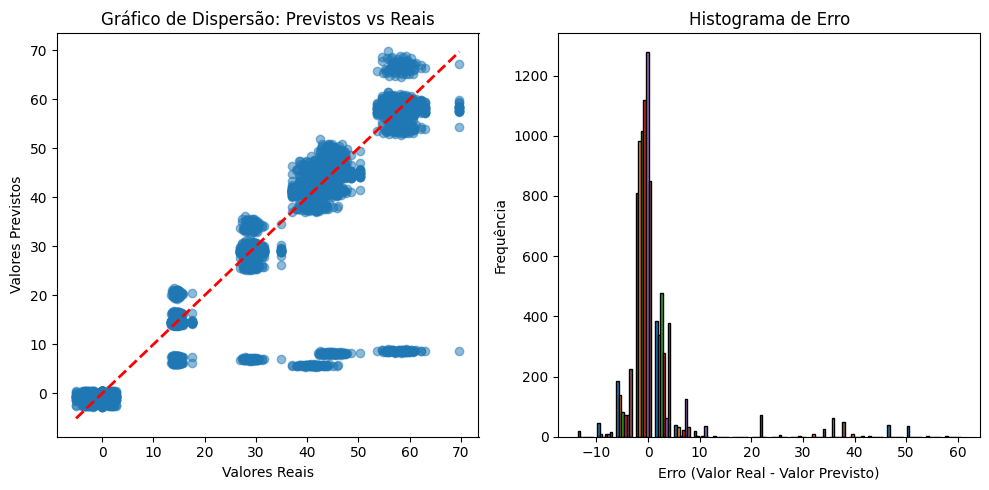

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico de dispersão e o histograma de erro
def plot_predictions_vs_actuals(y_true, y_pred):
    # Gráfico de dispersão
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Previstos vs Reais')

    # Histograma de erro
    erros = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.hist(erros, bins=20, edgecolor='black')
    plt.xlabel('Erro (Valor Real - Valor Previsto)')
    plt.ylabel('Frequência')
    plt.title('Histograma de Erro')

    plt.tight_layout()
    plt.show()



# Converta os tensores para numpy para plotagem
y_true_np = y_true.detach().cpu().numpy()
y_pred_np = y_pred.detach().cpu().numpy()

plot_predictions_vs_actuals(y_true_np, y_pred_np)


In [ ]:
from sklearn.metrics import mean_squared_error

test_losses = []
for epoch in range(num_epochs):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for data in test_loader:
      predictions = model(data.pos, data.batch)
      loss = criterion(predictions, data.y)
      running_loss += loss.item() * data.num_graphs
    total_loss = running_loss / len(test_loader.dataset)
    test_losses.append(total_loss)
    print(f'Test Loss after Epoch: [{epoch+1}/{num_epochs}], Loss: {total_loss}')




In [ ]:

import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label = "train loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses, label = "test loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()